In [30]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data

In [31]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Global values needed for hyperparameter tuning

In [53]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Naive dataset

In [33]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [34]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_shifted.append(accuracy_score(y_test_naive_shifted, y_pred))
    ROC_by_week_naive_shifted.append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive_shifted, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_shifted.append(sensitivity)
    specificity_by_week_naive_shifted.append(specificity)

    ppv_by_week_naive_shifted.append(ppv)
    npv_by_week_naive_shifted.append(npv)
    norm_MCC_by_week_naive_shifted.append((matthews_corrcoef(y_test_naive_shifted, y_pred) + 1)/2)


1
range(1, 3)
range(3, 4)
['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_five_']
['_five_', '_six_']
['_five_', '_six_', '_seven_']
2
range(1, 4)
range(4, 5)
['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_five_']
['_five_', '_six_']
['_five_', '_six_', '_seven_']
['_six_']
['_six_', '_seven_']
['_six_', '_seven_', '_eight_']
3
range(1, 5)
range(5, 6)
['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_five_']
['_five_', '_six_']
['_five_', '_six_', '_seven_']
['_six_']
['_six_', '_seven_']
['_six_', '_seven_', '_eight_']
['_seven_']
['_seven_', '_eight_']
['_seven_', '_eight_', '_nine_']
4
range(1, 6)
range(6, 7)
['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_f

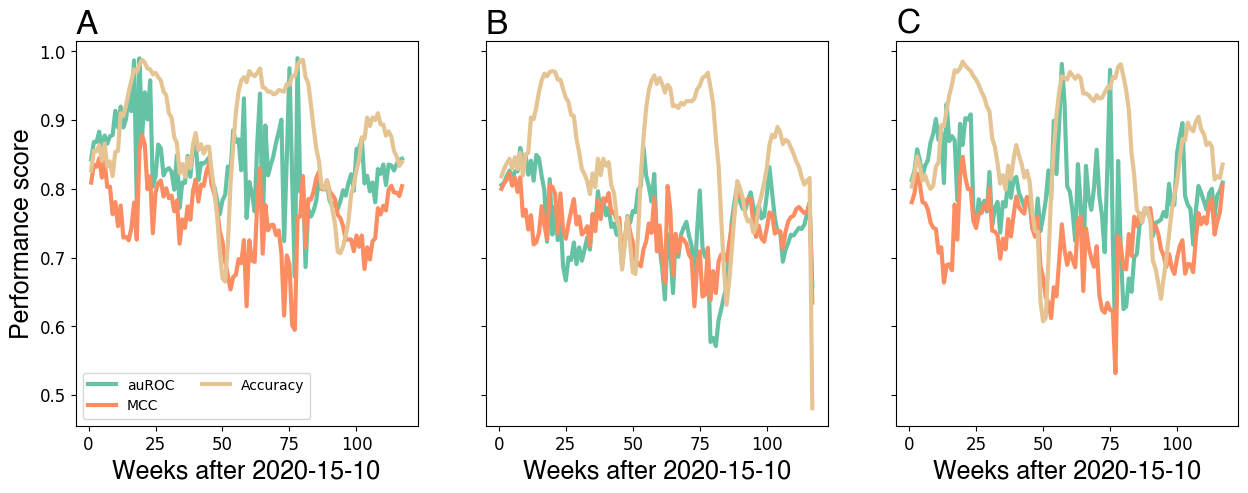

In [35]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])

# Plot data on the same plot
axs[1].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])

axs[2].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[2].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='MCC', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])

# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )
axs[2].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_expanding_train_models_period_exact_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

# Full Classifier

In [37]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)

In [47]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train, no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
    best_hyperparameters_per_iter = []
    auROC_per_iter = []

    for i in range(no_iterations):
        while True:
            # subset the HSAs from the full dataset
            geo_names = data[geography_column].unique()
            num_names_to_select = int(geo_split * len(geo_names))
            geos_for_sample = random.sample(list(geo_names), num_names_to_select)
            subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
            subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

            # create training and test data
            if time_period == 'period':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]
            elif time_period == 'exact':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]
            elif time_period == 'shifted':
                X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_train, no_weeks=no_weeks_train, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_test, no_weeks=no_weeks_test, weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
                weights_train = weights_train[0]

            # Check if y_sample_test contains only 1's
            if all(y == 1 for y in y_sample_test):
                break  # Repeat the sample procedure
            else:
                continue  # Exit the loop if y_sample_test is not all 1's

        random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
        random_search.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
        best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
        model = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
        model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
        y_pred = model_fit.predict_proba(X_sample_test)

        # Evaluate the accuracy of the model
        best_hyperparameters_per_iter.append(best_params)
        auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:, 1]))

    return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]

In [27]:
clf_full_period = DecisionTreeClassifier( random_state=10, class_weight='balanced')

In [42]:
    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_test, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)


In [44]:
y_test_full_period.sum()/len(y_test_full_period)

0    0.94625
dtype: float64

In [54]:
weeks_to_predict = range(1, 121 - size_of_test_dataset - 3 - train_weeks_for_initial_model) # first classifier has minimum train_weeks_for_initial_model weeks of data? 
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1)
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_train, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_test, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    pickle.dump(clf_full_period, open(model_name_to_save, 'wb'))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)
    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
